# Data Preparation

## Load data from sqlite3 in json

In [1]:
from utils.db.get_data_db import get_data_json

import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_01.db'
data = get_data_json(db_file_path)
#data

## Data cleaning

Keep only full registrations.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end_thanks":
        data_processed[p] = data[p]

# Number and Length of Selection boxes

In [3]:
p_tasks = {"p1":['t1','t2',"t3","t4",'t5'],"p2":['t6','t7',"t8","t9",'t10','t11'],"p3":['t12','t13',"t14","t15",'t16','t17','t18','t19']}
p_vars = {"p1":['a','b','c'],"p2":['a','b','c'],"p3":['a','b','c','d']}
p_inference = {"p1":np.load('data/min_temperature.npz') ,"p2":np.load('data/transformation.npz'),"p3":np.load('data/reaction_times_hierarchical.npz')}

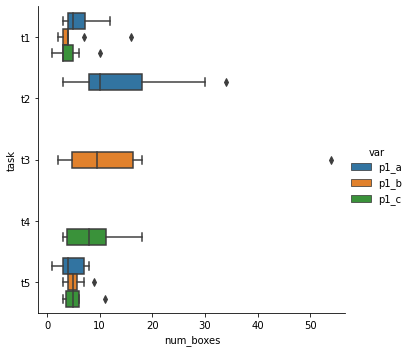

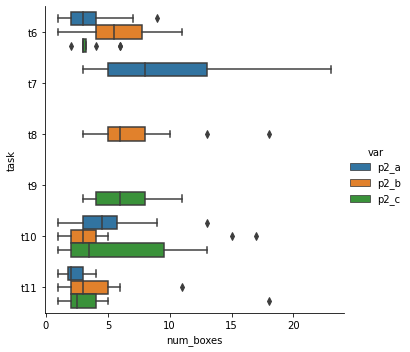

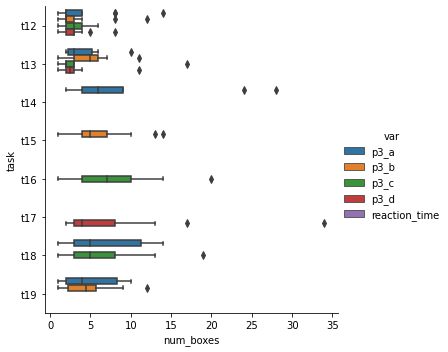

In [5]:
import pandas as pd
def get_num_of_boxes_df(data, p_tasks):
    i_logs = {} 
    i_logs["p_id"] = []
    i_logs["task"] = []
    i_logs["var"] = []
    i_logs["num_boxes"] = []
    for p_id,p in data.items():
        if p['mode'] == "i":        
            for t_id, t_response in p['t_answers'].items():
                num_boxes_dict = {}
                for i, sel in t_response['selections'].items():
                    if sel["var_name"] not in num_boxes_dict:
                        num_boxes_dict[sel["var_name"]] = 1
                    else:
                        num_boxes_dict[sel["var_name"]] = num_boxes_dict[sel["var_name"]] + 1
                vars_l = list(num_boxes_dict.keys())
                t_ids = [t_id]*len(vars_l)
                p_ids = [p_id]*len(vars_l)
                num_boxes = list(num_boxes_dict.values())
                i_logs["p_id"].extend(p_ids)
                i_logs["task"].extend(t_ids)
                i_logs["var"].extend(vars_l)
                i_logs["num_boxes"].extend(num_boxes)
    df = pd.DataFrame(i_logs) 
    # rename variables based on problem    
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='a')].replace(['a'],'p1_a')
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='b')].replace(['b'],'p1_b')
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='c')].replace(['c'],'p1_c')

    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='a')].replace(['a'],'p2_a')
    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='b')].replace(['b'],'p2_b')
    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='c')].replace(['c'],'p2_c')

    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='a')].replace(['a'],'p3_a')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='b')].replace(['b'],'p3_b')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='c')].replace(['c'],'p3_c')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='d')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='d')].replace(['d'],'p3_d')
    return df

var1 = ['p1_a','p1_b','p1_c']
var2 = ['p2_a','p2_b','p2_c']
var3 = ['p3_a','p3_b','p3_c','p3_d']
df_num = get_num_of_boxes_df(data_processed, p_tasks) 
g12 = sns.catplot(x="num_boxes", y="task", hue="var", kind="box", data = df_num.loc[df_num["task"].isin(p_tasks['p1'])  & df_num["var"].isin(var1)])
g22 = sns.catplot(x="num_boxes", y="task", hue="var", kind="box", data = df_num.loc[df_num["task"].isin(p_tasks['p2'])  & df_num["var"].isin(var2)])
g32 = sns.catplot(x="num_boxes", y="task", hue="var", kind="box", hue_order=["p3_a","p3_b","p3_c","p3_d","reaction_time"], data = df_num.loc[df_num["task"].isin(p_tasks['p3']) & df_num["var"].isin(var3)])

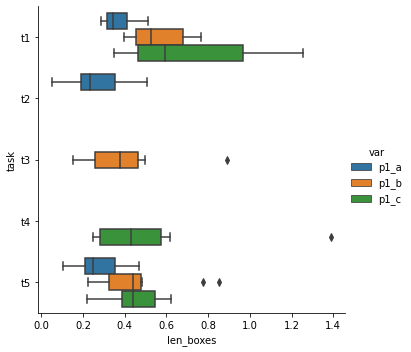

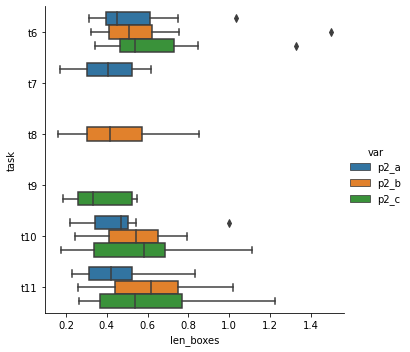

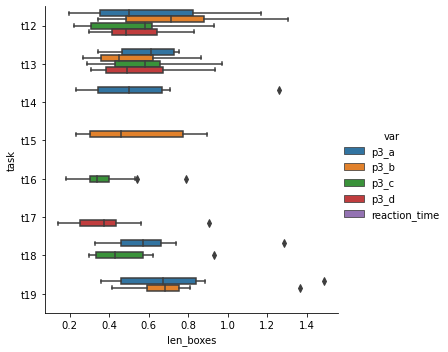

In [8]:
import json
import arviz as az
def get_len_of_boxes_df(data, p_tasks, p_vars, p_inference):
    """
        p_tasks: correspondence of tasks to problems {"p1":[t1,t2..],"p2":[]}
        p_vars:  correspondence of variables to problems {"p1":[a,b..],"p2":[a,b..]}
        p_inference: correspondence of inference to problems {"p1":{},"p2":{}}
    """
    i_logs = {} 
    i_logs["p_id"] = []
    i_logs["task"] = []
    i_logs["var"] = []
    i_logs["len_boxes"] = []
    # estimate range of each variable in each problem
    p_norm_factors = {}   
    for p, inference in p_inference.items():
        p_array_names = json.loads(p_inference[p]['header.json'])["inference_data"]["prior"]["array_names"]
        if p not in p_norm_factors:
            p_norm_factors[p] = {}
        for var in p_vars[p]:
            prior_samples = np.squeeze(p_inference[p][p_array_names[var]])
            if p == 'p3' and len(prior_samples.shape)>1:
                prior_samples = prior_samples[:,2]
#             p_norm_factors[p][var] =  prior_samples.max()-prior_samples.min()
            hdi = az.hdi(prior_samples, hdi_prob=.94)
            p_norm_factors[p][var] =  hdi[1] - hdi[0]
    #
    for p_id,p in data.items():
        if p['mode'] == "i":        
            for t_id, t_response in p['t_answers'].items():
                len_boxes_dict = {}
                if t_id in p_tasks['p1']:
                    prob = 'p1'
                elif t_id in p_tasks['p2']:
                    prob = 'p2'
                else:
                    prob = 'p3'
                for i, sel in t_response['selections'].items():
                    if sel["var_name"] not in p_vars[prob]:
                        continue
                    if sel["var_name"] not in len_boxes_dict:
                        len_boxes_dict[sel["var_name"]] = []
                    len_boxes_dict[sel["var_name"]].append((sel['xmax']-sel['xmin'])/p_norm_factors[prob][sel["var_name"]] )
                for var, lengths in len_boxes_dict.items():
                    len_boxes_dict[var] = np.median(lengths)
                vars_l = list(len_boxes_dict.keys())
                t_ids = [t_id]*len(vars_l)
                p_ids = [p_id]*len(vars_l)
                num_boxes = list(len_boxes_dict.values())
                i_logs["p_id"].extend(p_ids)
                i_logs["task"].extend(t_ids)
                i_logs["var"].extend(vars_l)
                i_logs["len_boxes"].extend(num_boxes)
    df = pd.DataFrame(i_logs) 
    # rename variables based on problem: a -> p1_a or p2_a or p3_a    
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='a')].replace(['a'],'p1_a')
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='b')].replace(['b'],'p1_b')
    df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p1'])) & (df['var']=='c')].replace(['c'],'p1_c')

    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='a')].replace(['a'],'p2_a')
    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='b')].replace(['b'],'p2_b')
    df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p2'])) & (df['var']=='c')].replace(['c'],'p2_c')

    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='a')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='a')].replace(['a'],'p3_a')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='b')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='b')].replace(['b'],'p3_b')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='c')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='c')].replace(['c'],'p3_c')
    df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='d')] = df.loc[(df['task'].isin(p_tasks['p3'])) & (df['var']=='d')].replace(['d'],'p3_d')
    return df

df_len = get_len_of_boxes_df(data_processed, p_tasks, p_vars, p_inference)
g12 = sns.catplot(x="len_boxes", y="task", hue="var", kind="box", data = df_len.loc[df_len["task"].isin(p_tasks['p1'])  & df_len["var"].isin(var1)])
g22 = sns.catplot(x="len_boxes", y="task", hue="var", kind="box", data = df_len.loc[df_len["task"].isin(p_tasks['p2'])  & df_len["var"].isin(var2)])
g32 = sns.catplot(x="len_boxes", y="task", hue="var", kind="box", hue_order=["p3_a","p3_b","p3_c","p3_d","reaction_time"],data = df_len.loc[df_len["task"].isin(p_tasks['p3']) & df_len["var"].isin(var3)])

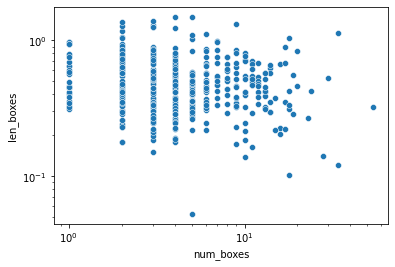

In [9]:
sns.scatterplot(y=df_len['len_boxes'],x=df_num['num_boxes'])
import matplotlib.pyplot as plt
plt.xscale('log')
plt.yscale('log')